# Methods for Data Science: Course Work 2

## Task 1: Neural Networks, Dimensionality Reduction and Mixture Models (65 marks)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
from scipy.sparse import linalg
from scipy.stats import multivariate_normal
from scipy.linalg import eigh
from scipy.special import logsumexp

In [3]:
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt

#### 1.1 Multi-Layer Perceptron (MLP) (25 marks)  

1.1.1

In [4]:
# read mnist data
mnist_test = np.loadtxt('/Users/xiaohengzhu/Desktop/All_CW2/CW2/MNIST_test.csv', delimiter=',', skiprows=1)
mnist_train = np.loadtxt('/Users/xiaohengzhu/Desktop/All_CW2/CW2/MNIST_train.csv', delimiter=',', skiprows=1)
x_test = mnist_test[:, 1:]
y_test = mnist_test[:, 0].astype(int)
x_train = mnist_train[:, 1:]
y_train = mnist_train[:, 0].astype(int)

# read noisy data
train_noisy = np.loadtxt(r'/Users/xiaohengzhu/Desktop/All_CW2/CW2/train_noise.txt')
test_noisy = np.loadtxt(r'/Users/xiaohengzhu/Desktop/All_CW2/CW2/test_noise.txt')

(1) **feed forward MLP**

Let $p_i$ denote the predicted probability from softmax output, $y_i$ denote the ground truth probability for class $i$. (In MNIST dataset, we have 10 classes, so $i \in \{ 0,1,...,10 \}$).

For ground truth label, we transform scalar label into one-hot encoding, so that $y_i=1$ when $i$ is the ground truth label, else $y_i=0$.

The formula of KL divergence loss:

$$
KL(y || p) = \sum_i y_i \log (\frac{y_i}{p_i})
$$

Overflow problems can occur when $p_i$ is close to zero numerically, so we transform the KL divergence function to add every $p_i$ to a small value $\epsilon$ to avoid such problem:

$$
KL(y || p) = \sum_i y_i \log (\frac{y_i}{p_i + \epsilon})
$$

Also, we can rewrite the formula with cross-entropy loss:

$$
KL(y || p) = \sum_i (y_i \log y_i - y_i \log p_i) \\
            = \sum_i (y_i \log y_i) - \sum_i (y_i \log p_i) \\
            =\sum_i (y_i \log y_i) + H(y, p)
$$

The first one is a constant, the second one is cross-entropy loss. So in the backprop stage, the error is the same as cross-entropy loss with softmax activation.

However, I use this just as a check of my output error function.

In [5]:
#standardise to make input data scaled properly
def standardise(X):
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xbar = ((X-mu)/std_filled)
    return Xbar
x_test_stan = standardise(x_test)
x_train_stan = standardise(x_train)
train_noisy_stan = standardise(train_noisy)
test_noisy_stan = standardise(test_noisy)
#Note that although I calculated the standardisation here, 
#I found that the accracy is actually higher when we train using the original x_train dataset,so I didn't use standardisation for 1.1

In [6]:
# dense function
def dense(x, W, b):
    
    # x: K x h_in array of inputs
    # W: h_in x h_out array for kernel matrix parameters
    # b: Length h_out 1-D array for bias parameters
    # returns: K x h_out output array 
    
    h = b + x @ W  
    return h

# softplus activation function
def softplus(h):
    
    # h: K x h_out array of pre-activations
    # returns: K x h_out output array 
    
    beta = 1
    h = np.clip(h, -500, 500)
    h = np.log(1 + np.exp(beta * h)) / beta 
    return h

# softmax activation function
def softmax(h):
    
    # h: K x h_out array of pre-activations
    # returns: K x h_out output array 
    
    m = np.max(h, axis=1).reshape(-1, 1)    
    h = np.exp(h-m) / np.sum(np.exp(h-m), axis=1).reshape(-1, 1)  

    return h

# KL divergence loss function
def KL_divergence_loss(p, y):

    # p: K x h_out array of output logits (pre-activations)
    # y: K x 1 array of ground truth label (not one-hot encoded)
    # returns: scalar loss value (averaged over batch samples)

    # kl divergence loss
    eps = 1e-5
    y_onehot = np.zeros_like(p)
    y_onehot[np.arange(y.size), y] = 1
    p = softmax(p) + eps
    y_onehot = y_onehot + eps
    loss = np.sum(y_onehot * np.log(y_onehot / p)) / len(p)
    
    return loss

In [7]:
# initialize the parameters in this question
input_dim = 28*28
hidden_dim = 200
output_dim = 10

def initialize_parameters():
    global W0, W1, W2, W3, W4
    global b0, b1, b2, b3, b4

    var_in = 2. / (input_dim + hidden_dim)
    W0 = np.random.randn(input_dim, hidden_dim) * np.sqrt(var_in)
    b0 = np.zeros(hidden_dim)

    var_hid = 2. / (hidden_dim + hidden_dim)
    W1 = np.random.randn(hidden_dim, hidden_dim) * np.sqrt(var_hid)
    W2 = np.random.randn(hidden_dim, hidden_dim) * np.sqrt(var_hid)

    b1 = np.zeros(hidden_dim)
    b2 = np.zeros(hidden_dim)


    var_out = 2. / (hidden_dim + output_dim)
    W3 = np.random.randn(hidden_dim, output_dim) * np.sqrt(var_out)
    b3 = np.zeros(output_dim)

def mlp(x):
    
    # x: K x 8 array of inputs
    # returns: K x 1 output array 
    
    a1 = dense(x, W0, b0)
    h1 = softplus(a1)
    a2 = dense(h1, W1, b1)
    h2 = softplus(a2)
    a3 = dense(h2, W2, b2)
    h3 = softplus(a3)
    a4 = dense(h3, W3, b3)
    h4 = softmax(a4)
    y  = h4
    return y

(2) **backprop**

In [8]:
def output_error(X, y):
    # X: K x 10 array of output pre-activations
    # y: K x 1 array of labels (not one-hot encoded)
    # returns: K x 10 array of output errors 

    # error of cross entropy loss is the same as kl divergence loss
    ones_true_class = np.zeros_like(X)
    ones_true_class[np.arange(len(X)),y] = 1
    
    # subtract the maximum value in each row of X to prevent overflow
    X_max = np.max(X, axis=1, keepdims=True)
    X_shifted = X - X_max
    
    softmax = np.exp(X_shifted) / np.exp(X_shifted).sum(axis=-1,keepdims=True)
    grad = (-ones_true_class + softmax) / X.shape[0]
    return grad

def activation_derivative(a1):
    
    # a1: K x hidden_dim array of hidden layer pre-activations
    # returns: K x hidden_dim array of diagonal elements  
    
    beta = 1
    #this is to avoid overflow
    a1 = np.clip(a1, -500, 500)
    return np.exp(beta*a1) / (1 + np.exp(beta*a1))

def backpropagate(delta2, W1, a1):
    
    # delta2: K x output_dim array of output errors
    # W1: input_dim x output_dim array
    # a1: K x input_dim array of hidden layer pre-activations
    # returns: K x input_dim array of hidden layer errors
    # K here is the minibatch size, hence we are applying the backpropagation formula 
    # for each sample in the mini-batch (this is why we use the element-wise product)  
    
    return np.squeeze(np.multiply(activation_derivative(a1)[:, None, :], np.dot(delta2[:, None, :], W1.T)))

def grads(delta_lst, h_lst):
    
    # returns: arrays for gradients
    
    dW_lst = []
    db_lst = []
    for i in range(4):
        dWi = delta_lst[i][:, np.newaxis, :] * h_lst[i][:, :, np.newaxis]
        dW_lst.append(np.mean(dWi, axis=0))
        dbi = delta_lst[i]
        db_lst.append(np.mean(dbi, axis=0))
    
    return dW_lst, db_lst

def apply_gradients(var_grads, lr=1e-5):

    # SGD method to update the parameters
    global W0, W1, W2, W3
    global b0, b1, b2, b3

    dW_lst = var_grads[0]
    db_lst = var_grads[1]
    
    W0 -= lr * dW_lst[0]
    W1 -= lr * dW_lst[1]
    W2 -= lr * dW_lst[2]
    W3 -= lr * dW_lst[3]

    b0 -= lr * db_lst[0]
    b1 -= lr * db_lst[1]
    b2 -= lr * db_lst[2]
    b3 -= lr * db_lst[3]
    
    return

In [9]:
# make train data batches
def batch(x_data,y_data,train_size,batch_size):
    train_data_x = []
    train_data_y = []
    for i in range(0, train_size//batch_size):
        x_batch = x_data[i:i+batch_size]
        y_batch = y_data[i:i+batch_size]
        train_data_x.append(x_batch)
        train_data_y.append(y_batch)
    return train_data_x,train_data_y

In [10]:
# train function
def train(x_data, y_data,x_test,y_test,lr,train_size,batch_size, epochs=40):
    initialize_parameters()
    losses = []
    test_losses = []
    acc_train_lst = []
    acc_test_lst = []
    for epoch in range(epochs):
        #This is to shuffle original dataset, so we have different input in different epoch
        p=np.random.permutation(len(x_data))
        x_data=x_data[p]
        y_data=y_data[p]
        for i in range(46):
            train_data_x,trian_data_y=batch(x_data,y_data,train_size,batch_size)
            a1 = dense(train_data_x[i], W0, b0)
            h1 = softplus(a1)
            a2 = dense(h1, W1, b1)
            h2 = softplus(a2)
            a3 = dense(h2, W2, b2)
            h3 = softplus(a3)
            a4 = dense(h3, W3, b3)
            y = softmax(a4)
            
            
            a1t = dense(x_test, W0, b0)
            h1t = softplus(a1t)
            a2t = dense(h1t, W1, b1)
            h2t = softplus(a2t)
            a3t = dense(h2t, W2, b2)
            h3t = softplus(a3t)
            a4t = dense(h3t, W3, b3)
            yt  = softmax(a4t)
            
            loss = KL_divergence_loss(a4, trian_data_y[i])
            losses.append(loss)
           
            delta4 = output_error(a4, trian_data_y[i])
            delta3 = backpropagate(delta4, W3, a3)
            delta2 = backpropagate(delta3, W2, a2)
            delta1 = backpropagate(delta2, W1, a1)
            
            test_loss = KL_divergence_loss(a4t,y_test)
            test_losses.append(test_loss)

            delta_lst = [delta1, delta2, delta3, delta4]
            h_lst = [train_data_x[i], h1, h2, h3]
            var_grads = grads(delta_lst, h_lst)
            
            apply_gradients(var_grads, lr)
            
        #to get the prediction
        y_pred_train = mlp(x_data)
        y_pred_test = mlp(x_test)
        #this defines the accuracy
        acc_train = np.sum(np.argmax(y_pred_train, axis=1) == y_data) / len(y_data)
        acc_test = np.sum(np.argmax(y_pred_test, axis=1) == y_test) / len(y_test)
        acc_train_lst.append(acc_train)
        acc_test_lst.append(acc_test)
        print("lr={}, epoch {}, train accuracy: {:.3f}, test accuracy: {:.3f}, train loss:{:.3f}, test loss:{:.3f} "
              .format(lr, epoch, acc_train,acc_test,loss,test_loss), end='\r')

    print("\n")
    return losses, test_losses, acc_train_lst, acc_test_lst, W0, b0


In [11]:
# run the training loop to find the optimal learning rate
epochs = 40
best_val_loss = np.inf
loopnum = 0
final_loss_train_lst=[]
final_loss_test_lst=[]
lr_lst = [1e-5, 1e-4, 1e-3,1e-2,5e-2, 1e-1]
for lr in lr_lst:
    losses, test_losses, acc_train_lst, acc_test_lst,W0, b0= train(x_train, y_train,x_test, y_test, lr,6000,128,epochs=40)
    final_loss_train_lst.append(losses[-1])
    final_loss_test_lst.append(test_losses[-1])

lr=1e-05, epoch 39, train accuracy: 0.117, test accuracy: 0.125, train loss:10.160, test loss:9.680 

lr=0.0001, epoch 39, train accuracy: 0.252, test accuracy: 0.279, train loss:7.065, test loss:7.177  

lr=0.001, epoch 39, train accuracy: 0.707, test accuracy: 0.685, train loss:2.261, test loss:2.755 

lr=0.01, epoch 39, train accuracy: 0.811, test accuracy: 0.779, train loss:0.134, test loss:1.862 

lr=0.05, epoch 39, train accuracy: 0.877, test accuracy: 0.836, train loss:0.001, test loss:1.265 

lr=0.1, epoch 39, train accuracy: 0.882, test accuracy: 0.802, train loss:0.001, test loss:1.494 



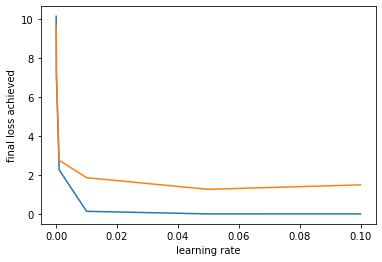

In [12]:
plt.figure()
plt.plot(lr_lst, final_loss_train_lst,label="train loss")
plt.plot(lr_lst, final_loss_test_lst,label="test loss")
plt.xlabel("learning rate")
plt.ylabel("final loss achieved")
plt.show()

The general pattern shows in the graph: as learning rate increases, the trend of final loss is generally decreasing unitil convergence for both train and test dataset. While in this question, according to the calculation above, we can see the optimal learning rate would be 0.05, where we achieve the highest accuracy and smallest loss for test set.

1.1.2

In [14]:
# retrain with optimal learning rate
optimal_lr = 5e-2
losses200, test_losses200, acc_train_lst200, acc_test_lst200,W0, b0 = train(x_train, y_train,x_test, y_test, optimal_lr,6000,128,epochs=40)

lr=0.05, epoch 39, train accuracy: 0.872, test accuracy: 0.828, train loss:0.002, test loss:1.428 



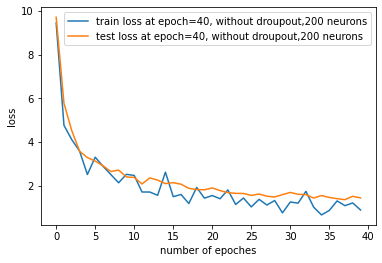

In [15]:
# plot loss w.r.t number of epoch
plt.figure()
plt.plot(np.arange(40), losses200[::int(len(losses200)/40)],label="train loss at epoch=40, without droupout,200 neurons")
plt.plot(np.arange(40), test_losses200[::int(len(test_losses200)/40)],label="test loss at epoch=40, without droupout,200 neurons")
plt.legend()
plt.xlabel("number of epoches")
plt.ylabel("loss")
plt.show()

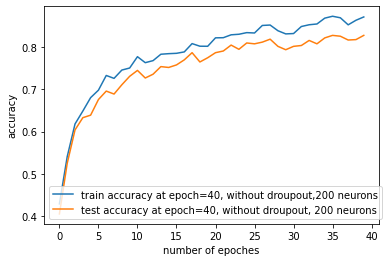

In [16]:
# plot train and test accuracy w.r.t number of epoch
plt.figure()
plt.plot(np.arange(40), acc_train_lst200, label="train accuracy at epoch=40, without droupout,200 neurons")
plt.plot(np.arange(40), acc_test_lst200, label="test accuracy at epoch=40, without droupout, 200 neurons")
plt.legend()
plt.xlabel("number of epoches")
plt.ylabel("accuracy")
plt.show()

1.1.3

In [18]:
# reduce the width of hidden layers to 50 neurons
optimal_lr = 1e-1
hidden_dim = 50
losses50, test_losses50, acc_train_lst50, acc_test_lst50,W0, b0 = train(x_train, y_train,x_test, y_test, optimal_lr,6000,128,epochs=40)

lr=0.1, epoch 39, train accuracy: 0.827, test accuracy: 0.786, train loss:0.142, test loss:1.261 



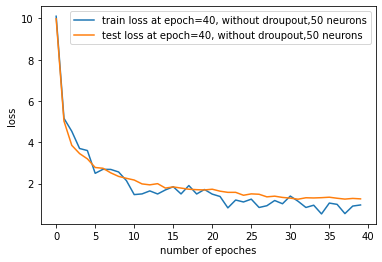

In [23]:
# plot loss w.r.t number of epoch
plt.figure()
plt.plot(np.arange(40), losses50[::int(len(losses50)/40)],label="train loss at epoch=40, without droupout,50 neurons")
plt.plot(np.arange(40), test_losses50[::int(len(test_losses50)/40)],label="test loss at epoch=40, without droupout,50 neurons")
plt.legend()
plt.xlabel("number of epoches")
plt.ylabel("loss")
plt.show()

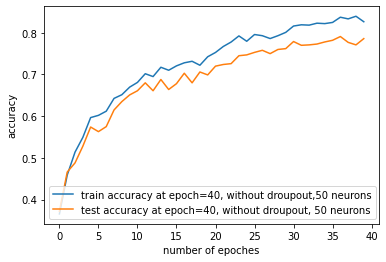

In [24]:
# plot train and test accuracy w.r.t number of epoch
plt.figure()
plt.plot(np.arange(40), acc_train_lst50, label="train accuracy at epoch=40, without droupout,50 neurons")
plt.plot(np.arange(40), acc_test_lst50, label="test accuracy at epoch=40, without droupout, 50 neurons")
plt.legend()
plt.xlabel("number of epoches")
plt.ylabel("accuracy")
plt.show()

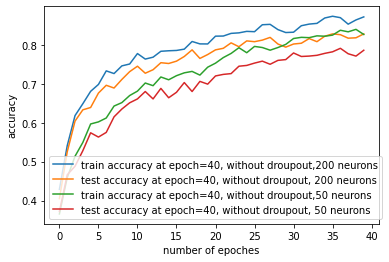

In [25]:
# plot train and test accuracy w.r.t number of epoch
plt.figure()
plt.plot(np.arange(40), acc_train_lst200, label="train accuracy at epoch=40, without droupout,200 neurons")
plt.plot(np.arange(40), acc_test_lst200, label="test accuracy at epoch=40, without droupout, 200 neurons")
plt.plot(np.arange(40), acc_train_lst50, label="train accuracy at epoch=40, without droupout,50 neurons")
plt.plot(np.arange(40), acc_test_lst50, label="test accuracy at epoch=40, without droupout, 50 neurons")
plt.legend()
plt.xlabel("number of epoches")
plt.ylabel("accuracy")
plt.show()

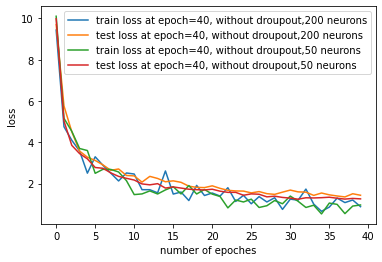

In [26]:
# plot train and test accuracy w.r.t number of epoch
plt.figure()
plt.plot(np.arange(40), losses200[::int(len(losses200)/40)],label="train loss at epoch=40, without droupout,200 neurons")
plt.plot(np.arange(40), test_losses200[::int(len(test_losses200)/40)],label="test loss at epoch=40, without droupout,200 neurons")
plt.plot(np.arange(40), losses50[::int(len(losses50)/40)],label="train loss at epoch=40, without droupout,50 neurons")
plt.plot(np.arange(40), test_losses50[::int(len(test_losses50)/40)],label="test loss at epoch=40, without droupout,50 neurons")
plt.legend()
plt.xlabel("number of epoches")
plt.ylabel("loss")
plt.show()

In the graph we can see as in both cases (hidden_dim=200 and hidden_dim=50):
- As the number of epoches increases, loss goes down, and will finally converge.
- As the number of epoches increases, accuracy will increase.
- In each graph, the loss of train set is lower than the loss of test set, while the accuracy of train set is higher than the accuracy of test set.
- This generally implies that the model is overfitting to the training data.
- The accuracy when hidden_dim=50 is lower, and the loss when hidden_dim=50 is slightly higher, for both train and data set. This indicates that the reduction of width of hidden layers has made the model too simple and is underfitting the data. The model has fewer parameters to learn and may not be able to capture the complexity of the data as well. 


1.3.4

In [27]:
# train function with dropout
dropout_rate = 0.2
def get_dropout_mask(h):
    d = np.random.rand(h.shape[0], h.shape[1])
    d = d < (1 - dropout_rate)
    return d

In [28]:
# initialize the parameters in this question
input_dim = 28*28
hidden_dim = 200
output_dim = 10

def initialize_parameters():
    global W0o, W1o, W2o, W3o
    global b0o, b1o, b2o, b3o

    var_in = 2. / (input_dim + hidden_dim)
    W0o = np.random.randn(input_dim, hidden_dim) * np.sqrt(var_in)
    b0o = np.zeros(hidden_dim)

    var_hid = 2. / (hidden_dim + hidden_dim)
    W1o = np.random.randn(hidden_dim, hidden_dim) * np.sqrt(var_hid)
    W2o = np.random.randn(hidden_dim, hidden_dim) * np.sqrt(var_hid)

    b1o = np.zeros(hidden_dim)
    b2o = np.zeros(hidden_dim)


    var_out = 2. / (hidden_dim + output_dim)
    W3o = np.random.randn(hidden_dim, output_dim) * np.sqrt(var_out)
    b3o = np.zeros(output_dim)
    
def mlp_o(x):
    
    # x: K x 8 array of inputs
    # returns: K x 1 output array 
    
    a1 = dense(x, W0o, b0o)
    h1 = softplus(a1)
    a2 = dense(h1, W1o, b1o)
    h2 = softplus(a2)
    a3 = dense(h2, W2o, b2o)
    h3 = softplus(a3)
    a4 = dense(h3, W3o, b3o)
    h4 = softmax(a4)
    y  = h4
    return y

def apply_gradients(var_grads, lr=1e-5):

    # SGD method to update the parameters
    global W0o, W1o, W2o, W3o
    global b0o, b1o, b2o, b3o

    dW_lst = var_grads[0]
    db_lst = var_grads[1]
    
    W0o -= lr * dW_lst[0]
    W1o -= lr * dW_lst[1]
    W2o -= lr * dW_lst[2]
    W3o -= lr * dW_lst[3]

    b0o -= lr * db_lst[0]
    b1o -= lr * db_lst[1]
    b2o -= lr * db_lst[2]
    b3o -= lr * db_lst[3]
    
    return

In [47]:
# train function
def train_drop(x_data, y_data,x_test,y_test,lr,train_size,batch_size, epochs=40):
    initialize_parameters()
    losses = []
    test_losses = []
    acc_train_lst = []
    acc_test_lst = []
    for epoch in range(epochs):
        #This is to shuffle original dataset, so we have different input in different epoch
        p=np.random.permutation(len(x_data))
        x_data=x_data[p]
        y_data=y_data[p]
        for i in range(46):
            train_data_x,trian_data_y=batch(x_data,y_data,train_size,batch_size)
                  
            a1 = dense(train_data_x[i], W0o, b0o)
            h1 = softplus(a1)
            d1 = get_dropout_mask(h1)
            h1 = np.multiply(d1, h1) / (1 - dropout_rate) 
            
            a2 = dense(h1, W1o, b1o)
            h2 = softplus(a2)
            d2 = get_dropout_mask(h2)
            h2 = np.multiply(d2, h2) / (1 - dropout_rate)
            
            a3 = dense(h2, W2o, b2o)
            h3 = softplus(a3)
            d3 = get_dropout_mask(h3)
            h3 = np.multiply(d3, h3) / (1 - dropout_rate)
               
            a4 = dense(h3, W3o, b3o)
            h4 = softmax(a4)
                  
            a1t = dense(x_test, W0o, b0o)
            h1t = softplus(a1t)
            a2t = dense(h1t, W1o, b1o)
            h2t = softplus(a2t)
            a3t = dense(h2t, W2o, b2o)
            h3t = softplus(a3t)
            a4t = dense(h3t, W3o, b3o)
            yt  = softmax(a4t)
            
            loss = KL_divergence_loss(a4, trian_data_y[i])
            losses.append(loss)
           
            delta4 = output_error(a4, trian_data_y[i])
            delta3 = backpropagate(delta4, W3o, a3)
            delta2 = backpropagate(delta3, W2o, a2)
            delta1 = backpropagate(delta2, W1o, a1)
            
            test_loss = KL_divergence_loss(a4t,y_test)
            test_losses.append(test_loss)

            delta_lst = [delta1, delta2, delta3, delta4]
            h_lst = [train_data_x[i], h1, h2, h3]
            var_grads = grads(delta_lst, h_lst)
            
            apply_gradients(var_grads, lr)
            
        #to get the prediction
        y_pred_train = mlp_o(x_data)
        y_pred_test = mlp_o(x_test)
        #this defines the accuracy
        acc_train = np.sum(np.argmax(y_pred_train, axis=1) == y_data) / len(y_data)
        acc_test = np.sum(np.argmax(y_pred_test, axis=1) == y_test) / len(y_test)
        acc_train_lst.append(acc_train)
        acc_test_lst.append(acc_test)
        print("lr={}, epoch {}, train accuracy: {:.3f}, test accuracy: {:.3f}, train loss:{:.3f}, test loss:{:.3f} "
              .format(lr, epoch, acc_train,acc_test,loss,test_loss), end='\r')

    print("\n")
    return losses, test_losses, acc_train_lst, acc_test_lst, W0o,b0o



In [48]:
#retain with dropout, now we use a higher epochs=70, in order to ensure the convergence of of the loss
optimal_lr = 5e-1
hidden_dim = 200
losses200d, test_losses200d, acc_train_lst200d, acc_test_lst200d,W0o,b0o = train_drop(x_train, y_train,x_test, y_test, optimal_lr,6000,128,epochs=70)

lr=0.5, epoch 69, train accuracy: 0.429, test accuracy: 0.406, train loss:1.701, test loss:1.665 



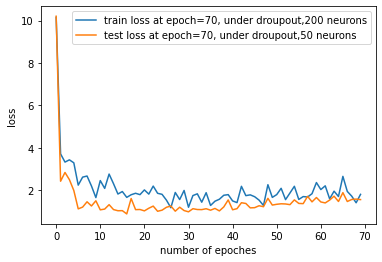

In [50]:
# plot loss w.r.t number of epoch
plt.figure()
plt.plot(np.arange(70), losses200d[::int(len(losses200d)/70)],label="train loss at epoch=70, under droupout,200 neurons")
plt.plot(np.arange(70), test_losses200d[::int(len(test_losses200d)/70)],label="test loss at epoch=70, under droupout,50 neurons")
plt.legend()
plt.xlabel("number of epoches")
plt.ylabel("loss")
plt.show()

We can see the loss for both train set and data set goes down, and fluctuates, due to the nature of stochastic gradient descent and might finally converge.

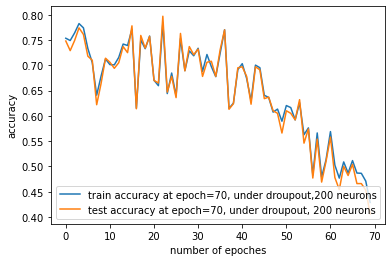

In [51]:
# plot train and test accuracy w.r.t number of epoch=65
plt.figure()
plt.plot(np.arange(70), acc_train_lst200d, label="train accuracy at epoch=70, under droupout,200 neurons")
plt.plot(np.arange(70), acc_test_lst200d, label="test accuracy at epoch=70, under droupout, 200 neurons")
plt.legend()
plt.xlabel("number of epoches")
plt.ylabel("accuracy")
plt.show()

As we can see from the graph that the accuracy for both train and test dataset actually goes down and both errors fluctuate at about 2, so the model doesnt become any better. And the possible reasons can be: dropout rate too high, network is too small/not complex enough, epoch not enough(that means we might still see a real convergence later on when learning rate and epochs reach large enough, while running time not allowed)

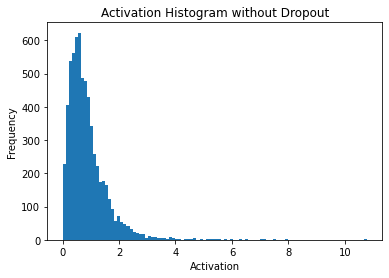

In [58]:
xx1=softplus((dense(x_test_stan[0:128], W0, b0)))
# plot the histogram of activations under dropout
#weights = np.ones_like(xx1.flatten())/float(len(xx1.flatten()))
plt.hist(xx1.flatten(),bins=100)
plt.xlabel('Activation')
plt.ylabel('Frequency')
plt.title('Activation Histogram without Dropout')
plt.show()


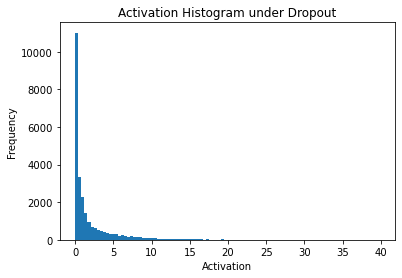

In [59]:
xx2=softplus((dense(x_test_stan[0:128], W0o, b0o)))
# plot the histogram of activations under dropout
#weights = np.ones_like(xx2.flatten())/float(len(xx2.flatten()))
plt.hist(xx2.flatten(),bins=100)
plt.xlabel('Activation')
plt.ylabel('Frequency')
plt.title('Activation Histogram under Dropout')
plt.show()


- From these two histogram, we can see that under dropout, the activation function in the first hidden layer has more values at 0, while distributed more spreadout. This shows the dropout is effective.
- Generally speaking, dropout can help to prevent overfitting.

#### 1.2 Dimensionality reduction (20 marks)

1.2.1

In [61]:
#standardise
def standardise(X):
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xbar = ((X-mu)/std_filled)
    return Xbar
#normalize
def normalize(X):
    X_norm = (X- np.min(X)) / (np.max(X) - np.min(X)) 
    return X_norm

In [62]:
#read data
noise_train_x = pd.read_csv(r'/Users/xiaohengzhu/Desktop/All_CW2/CW2/train_noise.txt',sep = " ",header=None).values
noise_test_x = pd.read_csv(r'/Users/xiaohengzhu/Desktop/All_CW2/CW2/test_noise.txt',sep = " ",header=None).values
train = pd.read_csv(r'/Users/xiaohengzhu/Desktop/All_CW2/CW2/MNIST_train.csv')
test = pd.read_csv(r'/Users/xiaohengzhu/Desktop/All_CW2/CW2/MNIST_test.csv')
train_x,train_y = train.iloc[:,1:].values,train.iloc[:,0].values
test_x,test_y = test.iloc[:,1:].values,test.iloc[:,0].values
#normalize
noise_train_x_norm,noise_test_x_norm = normalize(noise_train_x),normalize(noise_test_x)
non_train_x_norm,non_test_x_norm = normalize(train_x),normalize(test_x)
#standardise
noise_train_x_stand,noise_test_x_stand = standardise(noise_train_x),standardise(noise_test_x)
non_train_x_stand,non_test_x_stand = standardise(train_x),standardise(test_x)

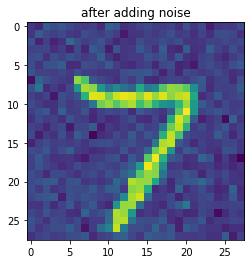

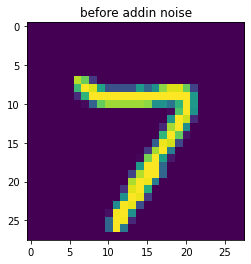

In [63]:
plt.imshow(noise_train_x[2].reshape(28,28))
plt.title("after adding noise")
plt.show()
plt.imshow(train_x[2].reshape(28,28))
plt.title("before addin noise")
plt.show()

In [64]:
def pca_function(X):

    # create covariance matrix C
    C = 1.0/(len(X)-1) * np.dot(X.T, X) 

    # compute eigenvalues and eigenvectors using the eigsh scipy function
    eigenvalues, eigenvectors = np.linalg.eig(C)
    # sorting the eigenvectors and eigenvalues from largest to smallest eigenvalue
    sorted_index = np.argsort(eigenvalues)[::-1]
    eigenvalues=eigenvalues[sorted_index]
    eigenvectors=eigenvectors[:,sorted_index ]

    return eigenvectors, eigenvalues


In [86]:
# compute the eigenvector and eigenvalues from our function
eigenvectors, eigenvalues = pca_function(noise_train_x_stand) 
# # compute explained_sum_variance_ratio_ for  each m
explained_variance_ratio_ = np.cumsum(eigenvalues) / sum(eigenvalues)
explained_variance_ratio_[:10]

array([0.04813222, 0.08271525, 0.11314116, 0.13806492, 0.15931632,
       0.17784282, 0.19330507, 0.20713976, 0.21979882, 0.23093896])

In [87]:
# find k respectively explain 70%, 80% and 90% of the variance
index1 = np.abs(explained_variance_ratio_ - 0.7).argmin()
index2 =  np.abs(explained_variance_ratio_ - 0.8).argmin()
index3 =  np.abs(explained_variance_ratio_ - 0.9).argmin()
print(" m and itd fraction of variance explained just reaching 70%, 80% 90% is:\n({},{}),\n({},{}),\n({},{})".format(index1+1,explained_variance_ratio_[index1],index2+1,explained_variance_ratio_[index2],index3+1,explained_variance_ratio_[index3]))

 m and itd fraction of variance explained just reaching 70%, 80% 90% is:
(213,0.7002033933233455),
(298,0.8003973524591995),
(407,0.8998094988152702)


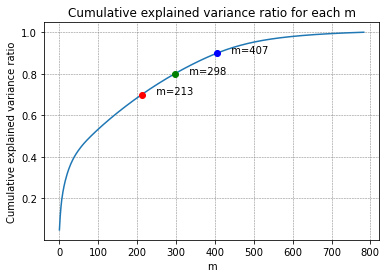

In [88]:
# figure
plt.plot(explained_variance_ratio_)
plt.xlabel('m')
plt.ylabel('Cumulative explained variance ratio')
plt.title('Cumulative explained variance ratio for each m')
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.plot(index1, 0.7, 'ro')
plt.plot(index2, 0.8, 'go')
plt.plot(index3, 0.9, 'bo')
plt.annotate('  m={}'.format(index1+1), (index1+20, 0.7))
plt.annotate('  m={}'.format(index2+1), (index2+20, 0.8))
plt.annotate('  m={}'.format(index3+1), (index3+20, 0.9))
plt.show()
plt.show()

As marked on the graph, the 3 m values at which 70%, 80% and 90% of the variance explained by PCA as m increases are 213,298 and 407.

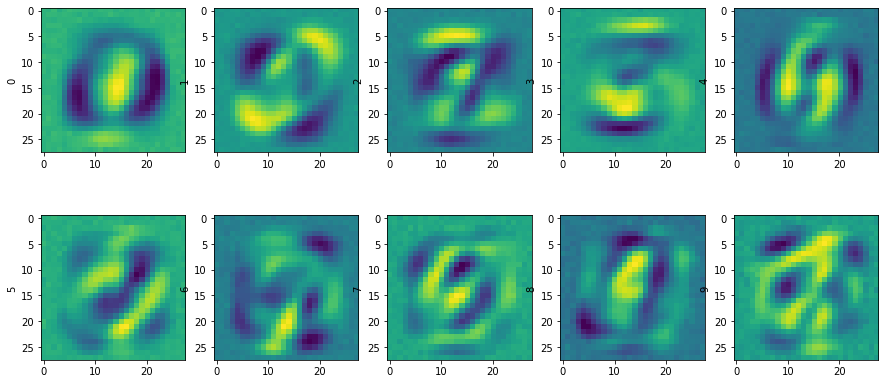

In [89]:
#visualise the first m=10 principal components from PCA
nrow = 2; ncol = 5;
fig, axs = plt.subplots(nrows=nrow, ncols=ncol,figsize=(15,7))

for i,ax in enumerate(axs.reshape(-1)): 
    ax.imshow(eigenvectors[:,i].reshape([28,28]))
    ax.set_ylabel(str(i))

1.2.2

</center>

A version of loss function based on the Euclidean distance is the following:

<center>
$
\chi^2 = \frac{e^⊤ (X \odot d \odot d) e}{n}
$
</center>

where d is the difference $d = X - WH$, and e is a vector of all ones where $e^⊤ K e$ simply performs a sum over all elements in K, and $n$ is the total number of elements in $X$. The symbol $\odot$ is the element wise product (Hadamard product).

In [182]:
# define a cost matrix to compare the difference
def cost1(X,W,H):
    # compute the difference between X and the dot product of W and H
    diff = X - np.dot(W, H) 
    chi2 = ((X*diff) * diff).sum() / (X.shape[0]*X.shape[1]) 
    return chi2
def NMF1(X,k,n_iters):
    k=10
    # k x P matrix interpreted as the basis set, where k is the number of components, P the number of descriptors of the data
    H = np.random.rand(k, X.shape[1])
    # N x k components matrix, usually interpreted as the coefficients, N is the number of data
    W = np.random.rand(X.shape[0], k)
    # set the number of iterations
    n_iters = 500
    pseudo_count = 0.0001 ## this is just a small value that we place at the denominator to avoid division by zero
    # empty list 
    cost_values1 = []
    # set the convergence threshold 
    eps = 1e-8
    # loop over the n iterations
    for i in range(n_iters):
        # compute the update on H
        H = H * ((W.T.dot(X))/(W.T.dot(W.dot(H))+pseudo_count))
        # compute the update on W
        W = W * ((X.dot(H.T))/(W.dot(H.dot(H.T))+pseudo_count)) 
        # compute the cost and append to list
        cur_cost = cost1(X,W,H)
        # if converge,earlystop
        if i > 1 and np.abs(cur_cost-cost_values1[-1])<eps:
            break
        cost_values1.append(cur_cost)
        print(f"Processing  {i/n_iters*100:0.2f}%", end="\r", flush=True)
    return W,H,cost_values1

In [183]:
_,noise_train_H1,cost_values1 = NMF1(noise_train_x_norm,10,500)

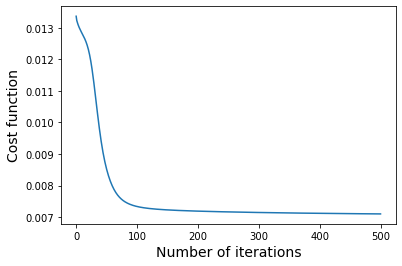

In [184]:
# plotting the cost
plt.plot(cost_values1)
plt.xlabel('Number of iterations', fontsize=14)
plt.ylabel('Cost function', fontsize=14)
plt.show()

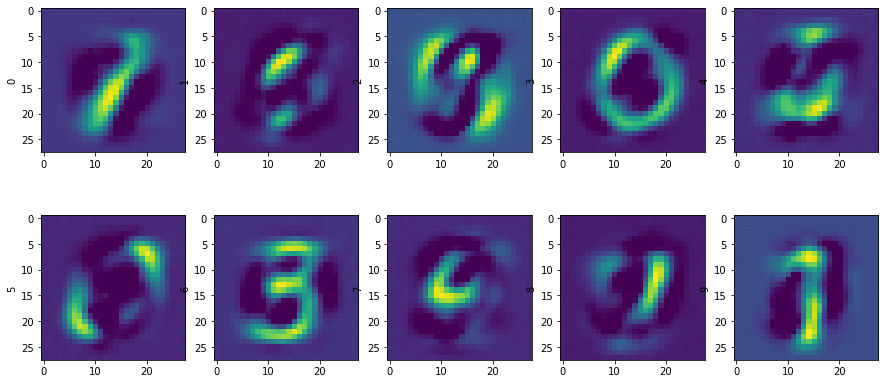

In [185]:
#visualise the first m=10 principal components from NMF
nrow = 2; ncol = 5;
fig, axs = plt.subplots(nrows=nrow, ncols=ncol,figsize=(15,7))
for i,ax in enumerate(axs.reshape(-1)): 
    ax.imshow(noise_train_H1[i].reshape([28,28]))
    ax.set_ylabel(str(i))

Comparison between NMF and PCA:
- On the NMF figure, many parts are shown in darker colors, which indicates that their values are closer to zero. However, on the PCA figure, we can observe numerous parts filled with different colors. This is because NMF enforces non-negativity constraints on its components, while PCA does not. The black shadow shown in the NMF graphs indicates that as the basic vectors of NMF cannot have negative values, it has more zero or very close to zero values.
- Compared with NMF, the visualized images of PCA components may have a slightly better interpretation. This is because the basis vectors obtained from PCA are always orthogonal to each other, these components are known as eigenvectors, and they are ordered by the amount of variance they explain in the data, and this variance represents information in the data. While the basis vectors obtained from NMF are not necessarily orthogonal. 
- The PCA graph shows that the first component is the most clear because theoretically it captures the most common features than following graphs by PCA. In the first picture the distinction between bight and dark pixels is greater. While NMF are equally clear with shadow between the digit itself and background.
- PCA aims to minimise approximation error of all images so captures the common features shared by these images. While NMF component can capture fewer main features/characters or strokes in this question.

1.2.3

In [186]:
# m = 100
m = 100
noise_train_x_NMF,_,__ = NMF1(noise_train_x_norm,100,500)

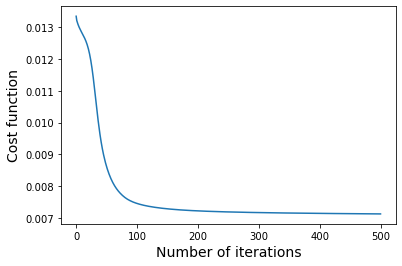

In [187]:
# figure to show NMF converges
plt.plot(__)
plt.xlabel('Number of iterations', fontsize=14)
plt.ylabel('Cost function', fontsize=14)
plt.show()

As we can see from the graph, the cost decreases in larger interations, and finally converge

In [188]:
#PCA for test
noise_test_x_PCA = noise_test_x_stand.dot(eigenvectors[:,:m])
# NMF for test, _ means H matrix from train data ,cause X = WH ,we have W = XH-1
noise_test_x_NMF = noise_test_x_norm.dot(np.linalg.pinv(_))

In [189]:
# reconstruct figures
#PCA
mu_noise_test = np.mean(noise_test_x, axis=0) 
std_noise_test = np.std(noise_test_x, axis=0)
std_noise_test[std_noise_test==0] = 1
reconstruc_test_PCA = noise_test_x_PCA.dot(eigenvectors[:,:m].T)*std_noise_test+mu_noise_test
#NMF
reconstruc_test_NMF=  noise_test_x_NMF.dot(_)

reconstruct figures from NMF


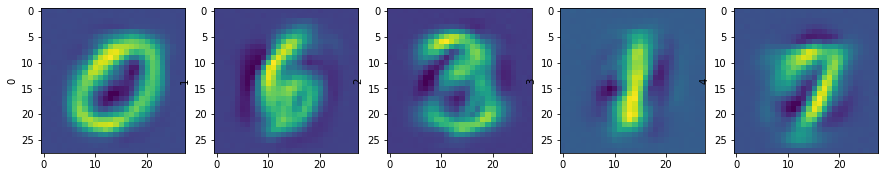

reconstruct figures from PCA


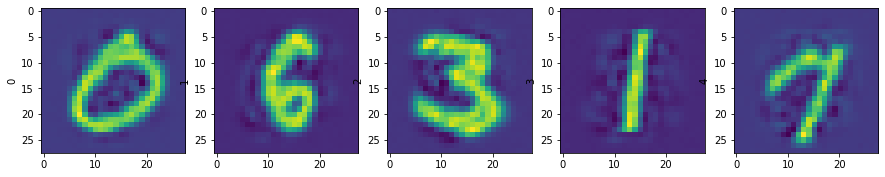

before denoise


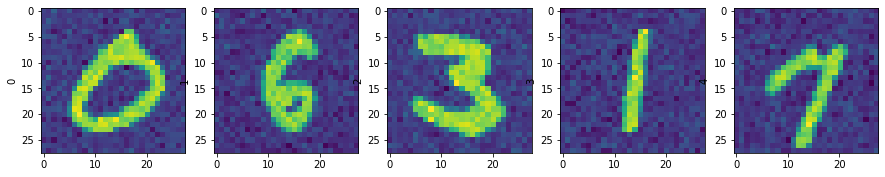

In [190]:
# show reconstructed image from PCA and NMF
fig, axs = plt.subplots(nrows=1, ncols=5,figsize=(15,3))
print("reconstruct figures from NMF")
for i,ax in enumerate(axs.reshape(-1)): 
    ax.imshow(reconstruc_test_NMF[i].reshape([28,28]))
    ax.set_ylabel(str(i))
plt.show()

fig, axs = plt.subplots(nrows=1, ncols=5,figsize=(15,3))
print("reconstruct figures from PCA")
for i,ax in enumerate(axs.reshape(-1)): 
    ax.imshow(reconstruc_test_PCA[i].reshape([28,28]))
    ax.set_ylabel(str(i))
plt.show()    
print("before denoise")
fig, axs = plt.subplots(nrows=1, ncols=5,figsize=(15,3))
for i,ax in enumerate(axs.reshape(-1)): 
    ax.imshow(noise_test_x[i].reshape([28,28]))
    ax.set_ylabel(str(i))
plt.show()

original


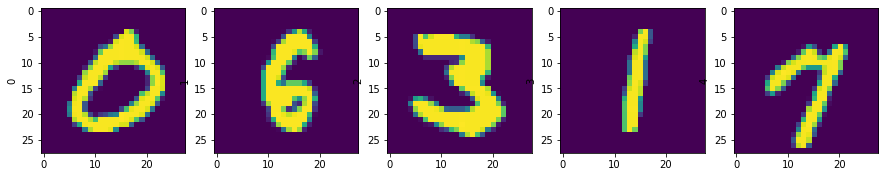

In [191]:
print("original")
fig, axs = plt.subplots(nrows=1, ncols=5,figsize=(15,3))
for i,ax in enumerate(axs.reshape(-1)): 
    ax.imshow(test_x[i].reshape([28,28]))
    ax.set_ylabel(str(i))
plt.show()

From figure above
- We could find that most noisy dots are removed, but there are still some noise dots around the border on the figure.
- Both methods have good results and we could see number clearly, and PCA performs better in covering more features of the digit required, while NMF is more effective in terms of denoising background, as we can see, there are very few noise dots in the background of the graph by NMF. While PCA figures a bit more noise dots compared with NMF even after reconstruction, It seems more difficult to deal with noise on the border around the digit
- For PCA, it involves some shadow between the digit itself and the background, so easier for recognizing digits. 
- A specific example can be the digit 6, NMF has missed the longer curve in 6, only left something looking like zero, while PCA captures very carefully, including the curve, the small circle, but it also involves more significant noise.


1.2.4

 now m is: 5
reconstruct figures from PCA


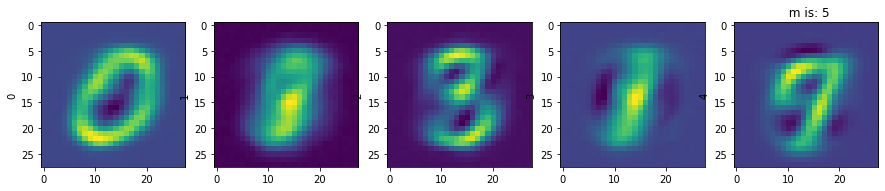

 now m is: 10
reconstruct figures from PCA


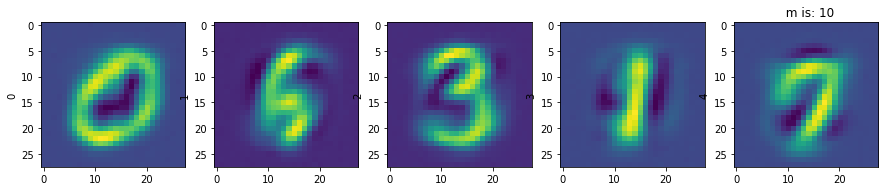

 now m is: 40
reconstruct figures from PCA


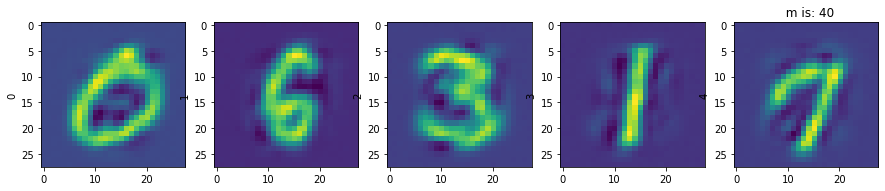

 now m is: 100
reconstruct figures from PCA


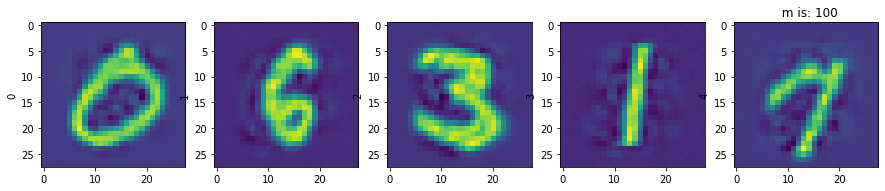

 now m is: 200
reconstruct figures from PCA


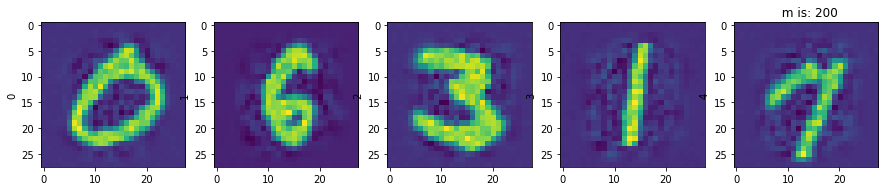

before denoise


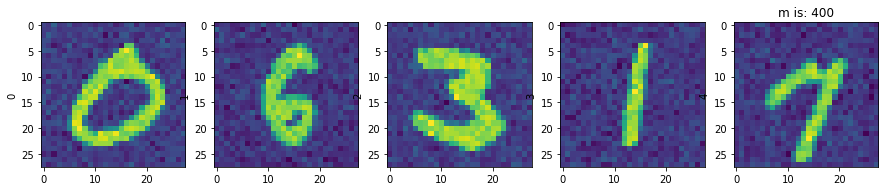

original


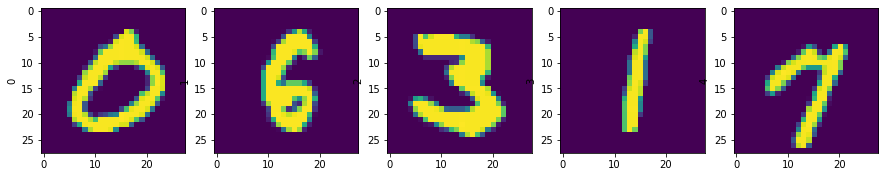

In [192]:
def mse(x,y):
    return np.sum((x-y)*(x-y))/(x.shape[0]*x.shape[1])
# compute MSE for each m, step by 5,for PCA
eigenvectors, eigenvalues = pca_function(noise_train_x_norm) 
mu_noise_test = np.mean(noise_test_x, axis=0) 
std_noise_test = np.std(noise_test_x, axis=0)
mse_PCA_noise_list,mse_PCA_true_list= [],[]
reconstruc_test_PCA_list,reconstruc_test_NMF_list = [],[]

for m in range(5,405,5):  
    noise_test_x_PCA = noise_test_x_stand.dot(eigenvectors[:,:m])
    reconstruc_test_PCA = noise_test_x_PCA.dot(eigenvectors[:,:m].T)*std_noise_test+mu_noise_test
    mse_PCA_noise = mse(reconstruc_test_PCA,noise_test_x)
    mse_PCA_noise_list.append(mse_PCA_noise)
    mse_PCA_true = mse(reconstruc_test_PCA,test_x)
    mse_PCA_true_list.append(mse_PCA_true)
    # mse_NMF_list.append(mse_NMF)
    if m in [5,10,40,100,200]:
        print(" now m is: {}".format(m))

        fig, axs = plt.subplots(nrows=1, ncols=5,figsize=(15,3))
        print("reconstruct figures from PCA")
        for i,ax in enumerate(axs.reshape(-1)): 
            ax.imshow(reconstruc_test_PCA[i].reshape([28,28]))
            ax.set_ylabel(str(i))
        plt.title("  m is: {}".format(m))
        plt.show()    
print("before denoise")
fig, axs = plt.subplots(nrows=1, ncols=5,figsize=(15,3))
for i,ax in enumerate(axs.reshape(-1)): 
    ax.imshow(noise_test_x[i].reshape([28,28]))
    ax.set_ylabel(str(i))
plt.title("m is: {}".format(m))
plt.show()
reconstruc_test_PCA_list.append(reconstruc_test_PCA.copy())
# reconstruc_test_NMF_list.append(reconstruc_test_NMF.copy())
print("original")
fig, axs = plt.subplots(nrows=1, ncols=5,figsize=(15,3))
for i,ax in enumerate(axs.reshape(-1)): 
    ax.imshow(test_x[i].reshape([28,28]))
    ax.set_ylabel(str(i))
plt.show()

From these set of graphs, we can notice that m becomes greater, the digit looks more clear, but at the same time the noise points become more significant as well. That's because, once we want to involve more features (m), the consequence is we need to afford more noise plots at the background, but these noice wont affact the recognization of the digit.
At the same time, the PCA method is very effective in denoising, as we can see the reconstruct figures involve less noise points, with just a few at the boarder.

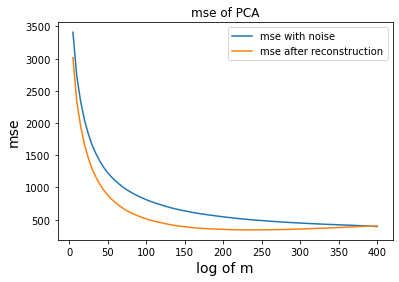

In [195]:
m = range(5,401, 5)
plt.plot((m),mse_PCA_noise_list,label = "mse with noise")
plt.plot((m),mse_PCA_true_list,label = "mse after reconstruction")
plt.xlabel('log of m', fontsize=14)
plt.ylabel('mse', fontsize=14)
plt.legend()
plt.title("mse of PCA")
plt.show()

Based on the above graph,

- It can be observed that with the increase of the number of principal components m, more information is retained,  the mean squared error (MSE) for both with-noise and without noise cases gradually decreases.
- PCA dimensionality reduction indeed has a noise reduction effect, as it can be observed that the MSE of the reconstructed image using PCA is smaller than the MSE of the noisy image, while the smaller the number of principal components m, the less significant noise.

#### 1.3 Gaussian Mixture Models (20 marks)
1.3.1

In [590]:
def pca_function_new(X,k):
    
    # create covariance matrix C
    C = 1.0/(len(X)-1) * np.dot(X.T, X) 

    # compute eigenvalues and eigenvectors using the eigsh scipy function
    eigenvalues, eigenvectors = linalg.eigsh(C, k, which="LM", return_eigenvectors=True) 
    # eigenvalues, eigenvectors = np.linalg.eig(C)
    # sorting the eigenvectors and eigenvalues from largest to smallest eigenvalue
    sorted_index = np.argsort(eigenvalues)[::-1]
    eigenvalues=eigenvalues[sorted_index]
    eigenvectors=eigenvectors[:,sorted_index ]
    x = np.dot(X,eigenvectors)
    return x

In [591]:
train_x = pd.read_csv(r'/Users/xiaohengzhu/Desktop/All_CW2/CW2/MNIST_train.csv').values
train_x,train_y = train_x[:,1:],train_x[:,0]
train_x_stand = standardise(train_x)
# reduce first 1000 data to 5 dimension
train_x_PCA = pca_function_new(train_x_stand[:1000],5)

In [592]:
class GMModel:
    """Struct to define Gaussian Mixture Model"""
    """:param dim: number of mixture components"""
    """:param weights: mixture weights"""
    """:param mu: mixture component means for each cluster"""
    """:param sigma: mixture component covariance matrix for each cluster"""
    
    def __init__(self, X, dim):
        """Initialises parameters through random split of the data"""
        
        self.dim = dim

        # initial weights given to each cluster are stored in phi or P(Ci=j)
        self.phi = np.full(shape=self.dim, fill_value=1/self.dim) 

        # initial weights given to each data point wrt to each cluster or P(Xi/Ci=j)
        self.weights = np.full(shape=X.shape, fill_value=1/self.dim)
        
        n,m = X.shape 
        # dataset is divided randomly into k parts of unequal sizes
        random_row = np.random.randint(low=0, high=n, size=self.dim)

        # initial value of mean of k Gaussians
        self.mu = [  X[row_index,:] for row_index in random_row ]  

        # initial value of covariance matrix of k Gaussians
        self.sigma = [ np.cov(X.T) for _ in range(self.dim) ] 

In [593]:
def cluster_probabilities(gmm, X):
    """Predicts probability of each data point with respect to each cluster"""
    
    # n has the number of rows while m has the number of columns of dataset X
    n,m = X.shape 
    # Creates a n*k matrix denoting likelihood belonging to each cluster 
    likelihood = np.zeros( (n, gmm.dim) ) 
    for i in range(gmm.dim):
        # likelihood of data belonging to i-th cluster 
        distribution = multivariate_normal(mean=gmm.mu[i],cov=gmm.sigma[i]) 
        likelihood[:,i] = distribution.pdf(X) 

        numerator = likelihood * gmm.phi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        weights = numerator / denominator
    return weights
def predict(gmm, X):
    """Performs hard clustering"""
    weights = cluster_probabilities(gmm,X)
    return np.argmax(weights, axis=1) ### <- fill in MAP estimate
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))

In [594]:
def plot_gmm(gmm, X, label=True,):
    plt.gca()
    labels = predict(gmm,X)
    if label:
        plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        plt.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    plt.show()
    w_factor = 0.2 / gmm.weights.max()
    # for pos, covar, w in zip(gmm.mu, gmm.sigma, gmm.phi):
    #     # print(pos,covar,w)
    #     draw_ellipse(pos, covar, alpha=w * w_factor)
    return None
def fitStep(gmm,X):
    """Performs an EM step by updating all parameters"""
    
    # E-Step: update weights and phi holding mu and sigma constant
    weights = cluster_probabilities(gmm,X) ### <- fill in
    gmm.phi = weights.mean(axis=0)
        
    # M-Step: update mu and sigma holding pi and weights constant
    for i in range(gmm.dim):
        weight = weights[:, [i]]
        total_weight = weight.sum()

        gmm.mu[i] = (X * weight).sum(axis=0) / total_weight 
        gmm.sigma[i] = np.cov(X.T,aweights=(weight/total_weight).flatten(), bias=True) ### <- fill in

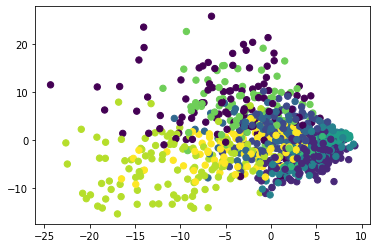

In [603]:
np.random.seed(669)
gmm10= GMModel(train_x_PCA,10)
for _ in range(1000):
    fitStep(gmm10,train_x_PCA)
plot_gmm(gmm10,train_x_PCA)

1.3.2

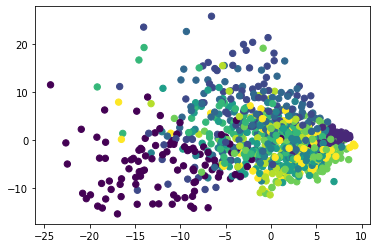

In [604]:
train_y = train_y[:1000]
# plot the result on the space spanned by the first two principal components 
plt.gca()
plt.scatter(train_x_PCA[:, 0], train_x_PCA[:, 1], c=train_y, s=40, cmap='viridis', zorder=2)
plt.show()

In [605]:
likelihood10 = cluster_probabilities(gmm10,train_x_PCA)
class_label_map10 = []
for i in range(10):
    # find the index of the data in the true label
    idx = np.where(train_y==i)[0]
    # compute the log likelihood of the data in the cluster
    log_likelihood10 = np.sum(np.log(likelihood10[idx]),axis=0)
    best_fit_cluster10 = np.argmax(log_likelihood10)
    class_label_map10.append(best_fit_cluster10) 
# class_label_map,here index means class, value means cluster
print(class_label_map10)

[8, 5, 0, 7, 3, 8, 0, 1, 8, 8]


/var/folders/1v/cyp_jc6546954nh5h9ktncxh0000gn/T/ipykernel_17885/4228992061.py:8: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.sum(np.log(likelihood[idx]),axis=0)


From the above results, it can be seen that the clustering effect is generally okay. Some classes are mapped to multiple clusters, such as digits 2, 6 all being mapped to the same class. This may indicate that in the actual clustering, it is not clear how to separate digits 2,6, leading to confusion. 

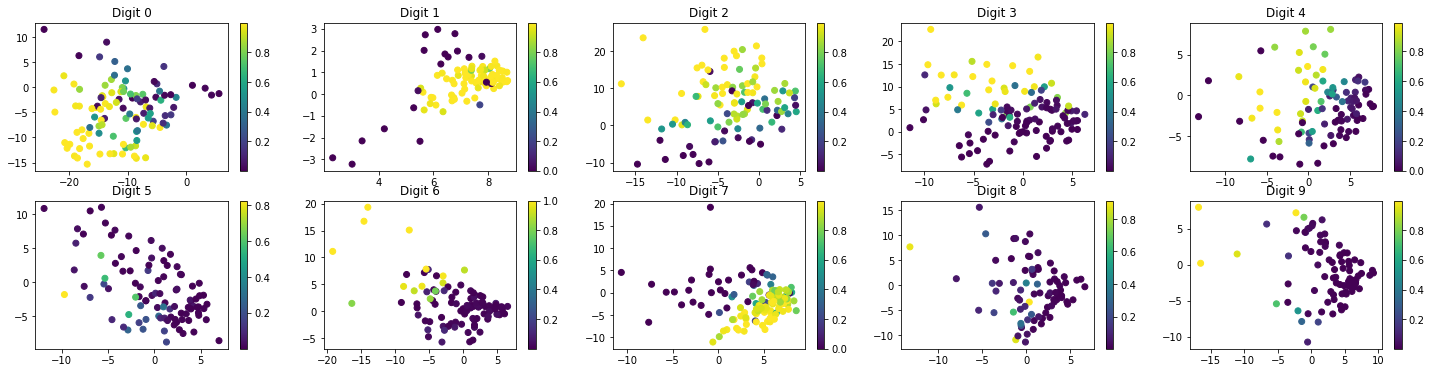

In [606]:
fig, axs = plt.subplots(nrows=2, ncols=5,figsize=(25,6))
for i,ax in enumerate(axs.reshape(-1)): 
    # get the indices of digits in class i
    idx = np.where(train_y == i)[0]
    
    # get the probabilities for these digits
    probs = likelihood10[idx, class_label_map10[i]]
    scatter = ax.scatter(train_x_PCA[idx, 0], train_x_PCA[idx, 1], c=probs, cmap='viridis')
    ax.set_title(f"Digit {i}")
    plt.colorbar(scatter, ax=ax)

-  From the above image, we can see that some classes have many bright points, such as the digit 1, indicating that most of the digits in that class are assigned to the best-fitting cluster, leading to better recognition.  However, some digits have very few bright points, indicating that the model's clustering performance on these digits is not very good and needs to be further improved. In general, according to the results in the above figure, the uncertainty of some digits, such as 1, is low, while some digits, such as 2, have higher uncertainty. That means if you pick up an element originally marked as digit 1, it's very likely their new label based on clustering is correct. While if you pick up an element originally marked as digit 8, it's very likely their new label based on clustering is wrong.
-  As we can see from the map lass labels, some digits are classified to the same cluster, say digit 2 and 6.

1.3.4

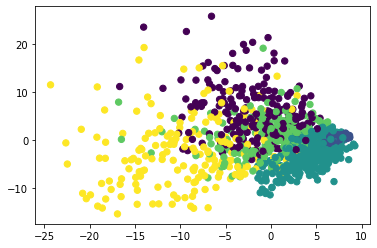

In [650]:
np.random.seed(685)
m = 5
gmm5 = GMModel(train_x_PCA,m)
for _ in range(1000):
    fitStep(gmm5,train_x_PCA)
plot_gmm(gmm5,train_x_PCA)

In [653]:
likelihood5 = cluster_probabilities(gmm5,train_x_PCA)
class_label_map5 = []
for i in range(10):
    # find the index of the data in the true label
    idx = np.where(train_y==i)[0]
    # compute the log likelihood of the data in the cluster
    log_likelihood5 = np.sum(np.log(likelihood5[idx]),axis=0)
    best_fit_cluster5 = np.argmax(log_likelihood5)
    class_label_map5.append(best_fit_cluster5) 
# class_label_map,here index means class, value means cluster
print(class_label_maps5)

[4, 1, 0, 0, 3, 4, 3, 3, 4, 3]


/var/folders/1v/cyp_jc6546954nh5h9ktncxh0000gn/T/ipykernel_17885/2819908029.py:7: RuntimeWarning: divide by zero encountered in log
  log_likelihood5 = np.sum(np.log(likelihood5[idx]),axis=0)


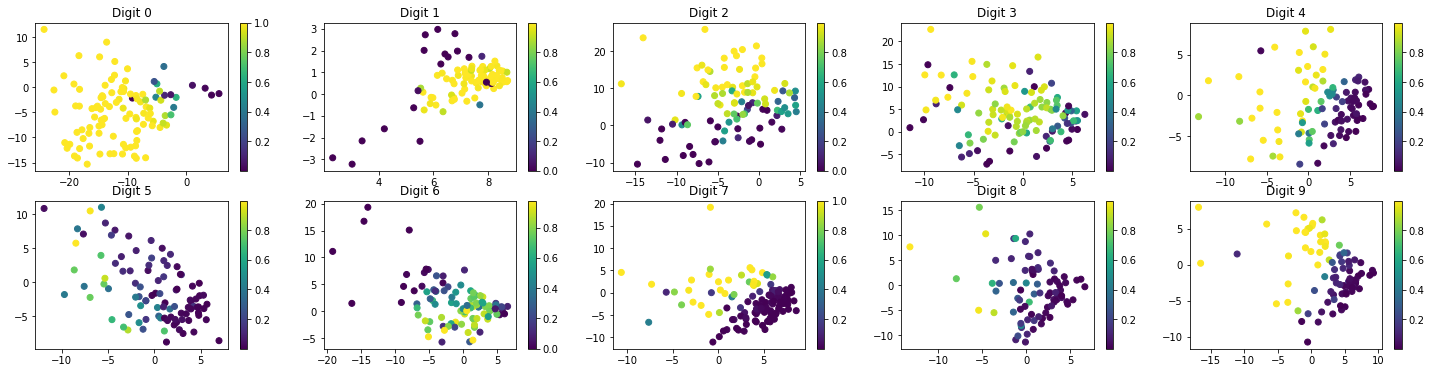

In [652]:
fig, axs = plt.subplots(nrows=2, ncols=5,figsize=(25,6))
for i,ax in enumerate(axs.reshape(-1)): 
    # get the indices of digits in class i
    idx = np.where(train_y == i)[0]
    
    # get the probabilities for these digits
    probs = likelihood5[idx, class_label_map5[i]]
    scatter = ax.scatter(train_x_PCA[idx, 0], train_x_PCA[idx, 1], c=probs, cmap='viridis')
    ax.set_title(f"Digit {i}")
    plt.colorbar(scatter, ax=ax)

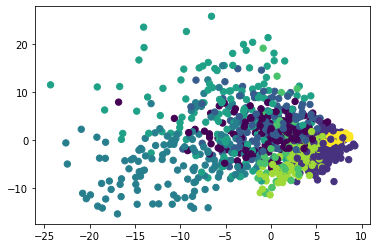

In [663]:
m = 8
gmm80 = GMModel(train_x_PCA,m)
for _ in range(1000):
    fitStep(gmm80,train_x_PCA)
plot_gmm(gmm80,train_x_PCA)

In [664]:
likelihood80 = cluster_probabilities(gmm80,train_x_PCA)
class_label_map80 = []
for i in range(10):
    # find the index of the data in the true label
    idx = np.where(train_y==i)[0]
    # compute the log likelihood of the data in the cluster
    log_likelihood80 = np.sum(np.log(likelihood80[idx]),axis=0)
    best_fit_cluster80 = np.argmax(log_likelihood80)
    class_label_map80.append(best_fit_cluster80) 
# class_label_map,here index means class, value means cluster
print(class_label_map80)

[3, 7, 4, 2, 0, 3, 4, 4, 3, 0]


/var/folders/1v/cyp_jc6546954nh5h9ktncxh0000gn/T/ipykernel_17885/3156764480.py:7: RuntimeWarning: divide by zero encountered in log
  log_likelihood80 = np.sum(np.log(likelihood80[idx]),axis=0)


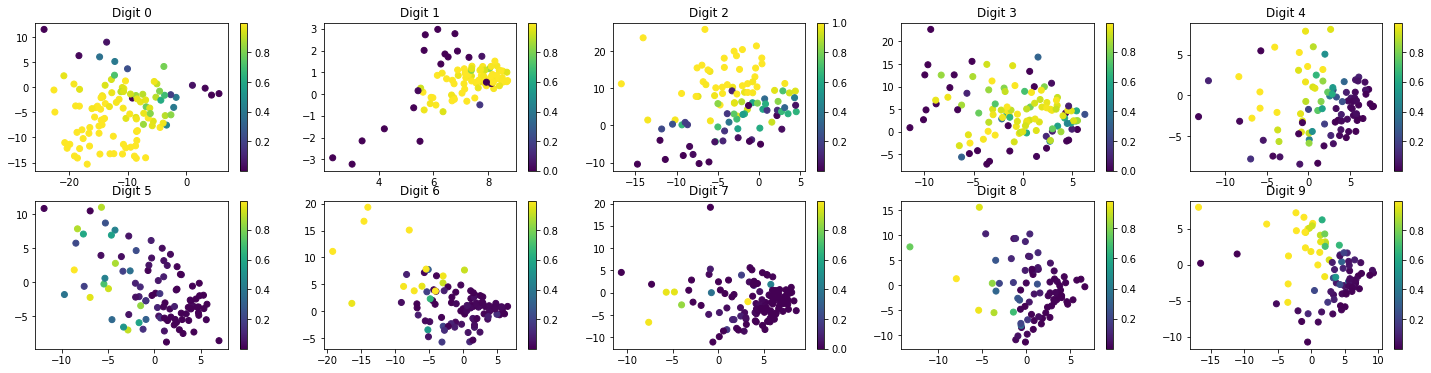

In [665]:
fig, axs = plt.subplots(nrows=2, ncols=5,figsize=(25,6))
for i,ax in enumerate(axs.reshape(-1)): 
    # get the indices of digits in class i
    idx = np.where(train_y == i)[0]    
    # get the probabilities for these digits
    probs = likelihood80[idx, class_label_map80[i]]
    scatter = ax.scatter(train_x_PCA[idx, 0], train_x_PCA[idx, 1], c=probs, cmap='viridis')
    ax.set_title(f"Digit {i}")
    plt.colorbar(scatter, ax=ax)

-  As we can see from these three sets of graphs, some digits with high certainty remain high certainty regardless of m, say digit 1, while some keep uncertainly, say digit 8, so sometimes from its original label, we might already be aware of the probability they are having correct new label.
-  Based on the comparison of class map clusters, we can see that when m=5 and m=8, the digits 6, 7 are still mapped to the same cluster, indicating that it is indeed difficult to distinguish these digits
-  Generally in a Gaussian Mixture Model when the number of components is reduced, the model becomes less complex and more generalizable, which can improve the clustering accuracy on unseen data. However, reducing the number of components too much can result in oversimplification and loss of important information.
-  Additionally, when m=10, more digits such as 0,5,8 and 9 are mapped to the same cluster, suggesting that its performance is relatively poor

### Task 2: Clustering and graph-based analysis (35 marks)

#### 2.1 Clustering (15 marks)
2.1.1

In [666]:
gene=pd.read_csv(r'/Users/xiaohengzhu/Desktop/All_CW2/CW2/gene_expression_data.csv')
# Convert 'Type' column into numerical labels and replace original column
gene['Type'] = pd.factorize(gene['Type'])[0]
data, y = gene.iloc[:,:-1], gene.iloc[:,-1]
data = data.values

In [667]:
# Define a function to compute the Calinski-Harabasz index
def calinski_harabasz(df, labels):
    # number of clusters
    k = len(np.unique(labels))
    # compute cluster centers
    centroids = np.array([np.mean(df[labels==c], axis=0) for c in range(k)])
    # compute within-cluster scatter matrix
    ssw = np.sum([np.sum((df[labels==c] - centroids[c])**2, axis=0) for c in range(k)])
    # compute between-cluster scatter matrix
    ssb = np.sum([len(df[labels==c]) * np.sum((centroids[c] - np.mean(data, axis=0))**2) for c in range(k)])
    # compute Calinski-Harabasz index
    ch = (ssb / (k-1)) / (ssw / (len(data) - k))
    return ch

k = 2
Calinski-Harabasz index: 370.8937949252614
Cluster sizes: [136, 664]
k = 3
Calinski-Harabasz index: 549.1983168844695
Cluster sizes: [136, 520, 144]
k = 4
Calinski-Harabasz index: 573.5551904997828
Cluster sizes: [135, 400, 122, 143]
k = 5
Calinski-Harabasz index: 497.8615113846438
Cluster sizes: [399, 122, 46, 98, 135]
k = 6
Calinski-Harabasz index: 418.7313451943575
Cluster sizes: [135, 189, 116, 143, 128, 89]
k = 7
Calinski-Harabasz index: 409.57113745594364
Cluster sizes: [135, 189, 116, 45, 128, 89, 98]
k = 8
Calinski-Harabasz index: 367.32924413674465
Cluster sizes: [45, 135, 121, 156, 98, 126, 32, 87]
k = 9
Calinski-Harabasz index: 340.8944985846985
Cluster sizes: [123, 74, 81, 61, 145, 41, 45, 98, 132]
k = 10
Calinski-Harabasz index: 318.13409032026885
Cluster sizes: [101, 76, 81, 59, 46, 41, 45, 98, 78, 175]
k = 11
Calinski-Harabasz index: 298.7794107717888
Cluster sizes: [95, 75, 77, 60, 45, 44, 45, 98, 43, 109, 109]
k = 12
Calinski-Harabasz index: 273.4059791554856
Clu

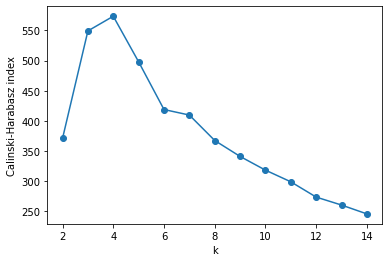

In [668]:
# Implement k-means clustering and compute Calinski-Harabasz index for different k values
max_iter = 15
n_init = 5
calinski_harabasz_indices = []
cluster_sizes = []
for k in range(2, 15):
    print('k =', k)
    best_calinski_harabasz_index = 0
    best_labels = None
    best_centroids = None
    for i in range(n_init):
        # Initialize centroids randomly
        centroids = data[np.random.RandomState(i).permutation(data.shape[0])[:k]]
        labels = np.zeros(len(data))
        difference = 0
        for j in range(max_iter):
            distances = np.array([np.linalg.norm(data-c, axis=1) for c in centroids])
            new_labels = np.argmin(distances, axis=0)
            if (labels==new_labels).all():
                # Labels unchanged
                labels = new_labels
                break
            else:
                # Labels changed
                difference = np.mean(labels!=new_labels)
                labels = new_labels
                for c in range(k):
                    # update centroids by taking the mean over associated data points
                    if (labels == c).any():
                        centroids[c] = np.mean(data[labels==c], axis=0)
        calinski_harabasz_index = calinski_harabasz(data, labels)
        if calinski_harabasz_index > best_calinski_harabasz_index:
            best_calinski_harabasz_index = calinski_harabasz_index
            best_labels = labels
            best_centroids = centroids
    print('Calinski-Harabasz index:', best_calinski_harabasz_index)
    print('Cluster sizes:', [sum(best_labels==c) for c in range(k)])
    calinski_harabasz_indices.append(best_calinski_harabasz_index)
    cluster_sizes.append([sum(best_labels==c) for c in range(k)])

# Plot the Calinski-Harabasz indices as a function of k
plt.plot(range(2, 15), calinski_harabasz_indices, '-o')
plt.xlabel('k')
plt.ylabel('Calinski-Harabasz index')
plt.show()

According to the graph, we can notice that Calinski-Harabasz index achieves the maximum when k=4, and in this case cluster size is [135,400,122,143].

2.1.2

In [673]:
# inplement k-means cluster based on the optimal k=4
def k_means(df,k,max_iter=15, n_init=5):
    best_calinski_harabasz_index = 0
    best_labels = None
    best_centroids = None
    for i in range(n_init):
        # Initialize centroids randomly
        centroids = data[np.random.RandomState(i).permutation(data.shape[0])[:k]]
        labels = np.zeros(len(data))
        difference = 0
    
        for j in range(max_iter):
            print('Iteration:', j)
            # distances: between data points and centroids
            distances = np.array([np.linalg.norm(df - c, axis=1) for c in centroids])
            # new_labels: computed by finding centroid with minimal distance
            new_labels = np.argmin(distances, axis=0)

            if (labels==new_labels).all():
                # labels unchanged
                labels = new_labels
                print('Labels unchanged! Terminating k-means.')
                break
            else:
                # labels changed
                # difference: percentage of changed labels
                difference = np.mean(labels!=new_labels)    ## <-- EDIT THIS LINE
                print('%4f%% labels changed' % (difference * 100))
                labels = new_labels
                for c in range(k):
                    # update centroids by taking the mean over associated data points
                    if (labels == c).any():
                        centroids[c] = np.mean(df[labels==c], axis=0) 
    calinski_harabasz_index = calinski_harabasz(df, labels)
    if calinski_harabasz_index > best_calinski_harabasz_index:
            best_calinski_harabasz_index = calinski_harabasz_index
            best_labels = labels
            best_centroids = centroids
    return best_labels, best_centroids, best_calinski_harabasz_index
y_pred=k_means(data,4,max_iter=15, n_init=5)[0]

Iteration: 0
83.125000% labels changed
Iteration: 1
4.875000% labels changed
Iteration: 2
Labels unchanged! Terminating k-means.
Iteration: 0
70.875000% labels changed
Iteration: 1
27.375000% labels changed
Iteration: 2
7.000000% labels changed
Iteration: 3
0.250000% labels changed
Iteration: 4
Labels unchanged! Terminating k-means.
Iteration: 0
64.500000% labels changed
Iteration: 1
22.125000% labels changed
Iteration: 2
16.625000% labels changed
Iteration: 3
9.625000% labels changed
Iteration: 4
1.875000% labels changed
Iteration: 5
0.125000% labels changed
Iteration: 6
Labels unchanged! Terminating k-means.
Iteration: 0
74.375000% labels changed
Iteration: 1
29.875000% labels changed
Iteration: 2
8.500000% labels changed
Iteration: 3
2.125000% labels changed
Iteration: 4
1.125000% labels changed
Iteration: 5
2.000000% labels changed
Iteration: 6
3.125000% labels changed
Iteration: 7
5.750000% labels changed
Iteration: 8
1.875000% labels changed
Iteration: 9
Labels unchanged! Termina

In [674]:
def contingency_matrix(y_true,y_pred):
    """
    Compute the contingency matrix for the given data
    Args:
    - y_true: true labels
    - y_pred: predicted labels
    Returns:
    - res: the contingency matrix
    """
    # compute the contingency matrix
    unique_pred = np.unique(y_pred)
    unique_true = np.unique(y_true)
    res = np.zeros((len(unique_true),len(unique_pred))).astype("int")
    for i in range(len(unique_true)):
        for j in range(len(unique_pred)):
            res[i,j] = np.sum((y_true==unique_true[i])&(y_pred==unique_pred[j]))
    return res
def homogeneity_score(y_true,y_pred):
    """
    Compute the homogeneity score for the given data
    Args:
    - y_true: true labels
    - y_pred: predicted labels
    Returns:
    - the homogeneity score
    """
    N = len(y_true)
    cont_matrix = contingency_matrix(y_true,y_pred)
    # add a small number to avoid log(0)
    eps = 1e-8
    cont_matrix = np.where(cont_matrix == 0, eps, cont_matrix)
    # compute H(C)
    H_C =  -np.sum(np.sum(cont_matrix,axis=1)/N*np.log(np.sum(cont_matrix,axis=1)/N))
    # compute H(C|K)
    H_CK = -np.sum(cont_matrix * np.log(cont_matrix/np.sum(cont_matrix, axis=0)))/N
    return 1-H_CK/H_C
cont_matrix3 = contingency_matrix(y,y_pred)
result=homogeneity_score(y,y_pred)
result

0.6653242467104814

Homogeneity measures how much the sample in a cluster are similar. Here homogeneity score is a bit higher than 0.5. It indicates that the clustering has moderate homogeneity, many clusters are consistent with other nodes in the same cluster partition in terms of the original tumour sample. If the original types of nodes are also consistent with these labels or categories, then we can say that the clusters are consistent with the original types.

#### 2.2 Graph-based analysis (20 marks)
2.2.1

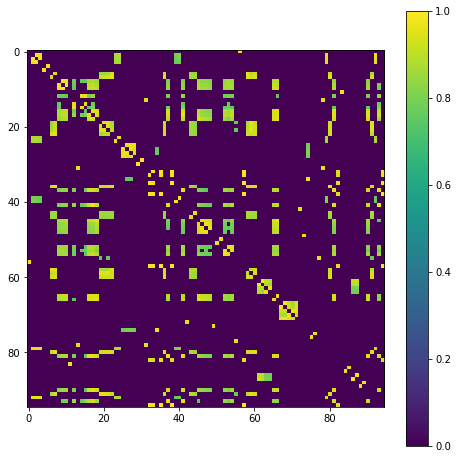

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.99321014, ..., 0.96005422, 0.        ,
        0.        ],
       [0.        , 0.99321014, 0.        , ..., 0.96337604, 0.        ,
        0.        ],
       ...,
       [0.        , 0.96005422, 0.96337604, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [675]:
# compute the correlation matrix
correlation_matrix = np.corrcoef(data, rowvar=False)
# set the threshold of the correlation matrix, only keep the elements with absolute value larger than 0.75
correlation_matrix[np.abs(correlation_matrix) < 0.75] = 0
# set the diagonal elements to 0
np.fill_diagonal(correlation_matrix, 0)

# set the adjacency matrix
adjacency_matrix = correlation_matrix

# plot the adjacency matrix
plt.figure(figsize=(8,8))
plt.imshow(adjacency_matrix)
plt.colorbar()
plt.show()
adjacency_matrix

2.2.2

In [680]:
# compute degree of each node
degree = np.sum(adjacency_matrix,axis=1)
degree_centrality = degree/np.sum(degree)
# sort in descending order
sorted_genes_idx = np.argsort(degree_centrality)[::-1]
genes_name =pd.read_csv(r'/Users/xiaohengzhu/Desktop/All_CW2/CW2/gene_expression_data.csv').columns.values
#sort out the 5 top ranking genes
top_5_genes = genes_name[sorted_genes_idx[:5]]
print("top 5 genes are: {}".format(top_5_genes), "and their degree centrality are: {}".format(degree_centrality[sorted_genes_idx[:5]]))

top 5 genes are: ['Gene 17' 'Gene 41' 'Gene 16' 'Gene 81' 'Gene 90'] and their degree centrality are: [0.02687344 0.02593545 0.02537837 0.02523066 0.02487023]


2.2.3

In [681]:
from scipy.sparse import linalg
# define diagonal matrix of node degrees
weighted_degree = adjacency_matrix.sum(axis=1) 
# create diagonal matrix of degree
D = np.diag(weighted_degree)

In [682]:
# define Laplacian
L = D-adjacency_matrix
# computing inverse square root vector of degree
weighted_degree_sqrt = 1.0 / np.sqrt(weighted_degree)
# set a diagonal matrix of the inverse square root of degree
D_inv_sqrt = np.diag(weighted_degree_sqrt)
# define the normalised Laplacian
L_norm = np.eye(adjacency_matrix.shape[0]) - D_inv_sqrt.dot(adjacency_matrix.dot(D_inv_sqrt))

In [683]:
# Compute eigenvalues and eigenvectors
eigenvals, eigenvecs = np.linalg.eig(L_norm)
# Sort eigenvalues in ascending order
idx = np.argsort(eigenvals)
eigenvals = eigenvals[idx]
eigenvecs = eigenvecs[:, idx]

/Users/xiaohengzhu/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(23, (0.049999999999999656+0j), 'Gap: 0.44+0.00j')

/Users/xiaohengzhu/opt/anaconda3/lib/python3.9/site-packages/matplotlib/text.py:831: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(self._y))
/Users/xiaohengzhu/opt/anaconda3/lib/python3.9/site-packages/matplotlib/text.py:691: ComplexWarning: Casting complex values to real discards the imaginary part
  posy = float(self.convert_yunits(self._y))


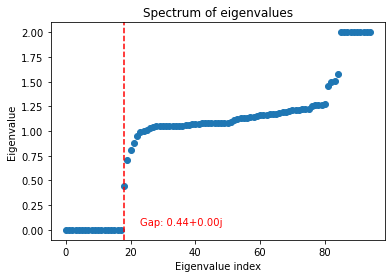

In [684]:
# Plot the spectrum of eigenvalues
plt.plot(eigenvals, 'o')
plt.xlabel('Eigenvalue index')
plt.ylabel('Eigenvalue')
plt.title('Spectrum of eigenvalues')
# compute the difference between two adjacent eigenvalues
nei_diff = np.diff(eigenvals)
# Identify the gap between zero and non-zero eigenvalues
tolerance = 1e-10
gap_idx = np.argmax(np.abs(np.diff(eigenvals)) > tolerance) + 1
gap_eigenval = eigenvals[gap_idx]
# Mark the gap on the plot
plt.axvline(x=gap_idx, color='r', linestyle='--')
plt.text(gap_idx + 5, eigenvals[0] + 0.05, f"Gap: {gap_eigenval:.2f}", color='r')


The number of zero eigenvalues of the Laplacian equals the number of connected components of the graph G, and here the number is 18.

2.2.4

In [697]:
# extract eigenvectors corresponding to zero eigenvalues
U = eigenvecs[:,:gap_idx]
denominator = np.sqrt(np.sum(U**2, axis=1, keepdims=True))
denominator = np.where(denominator == 0, 1e-16, denominator)
# normalize rows of U
T = U/denominator

In [698]:
def within_distance(X, labels):
    # compute the within distance of a clustering
    k = np.max(labels) + 1 
    W = 0
    for l in range(k):
        idx = np.where(labels == l)[0]  # get the index of the samples in the lth cluster
        n = len(idx)  # number of samples in the lth cluster
        if n > 0:
            X_l = X[idx, :]  # get the samples in the lth cluster
            D_l = np.sum((X_l[:, np.newaxis, :] - X_l[np.newaxis, :, :])**2)  # compute the distance between each pair of samples in the lth cluster
            W += 0.5 * D_l / n  # compute the within distance of the lth cluster
    return W

In [713]:
def K_means(data,k_prime,iteration = 500,eps = 1e-8,earlystop = True):
    """
    K-means algorithm
    Args:
    - data: the data to be clustered
    - k_prime: the number of clusters
    - iteration: the number of iterations
    - eps: the threshold of the change of the objective function
    - earlystop: whether to stop the iteration when the objective function does not change
    Returns:
    - cls: the class of each data point
    """
    n,m = data.shape[0],data.shape[1]
    # randomly initialize the centroids
    center = data[np.random.choice(n,k_prime,replace=False),:]
    # randomly initialize the centroids
    dis = 0
    for i in range(iteration):
        data_broad = data[:,np.newaxis,:]
        center_broad = center[np.newaxis,:,:]
        distance = np.sum((data_broad-center_broad)**2,axis = 2)
        # predict the class of each data point
        cls = np.argmin(distance,axis=1)
        # get index of each class
        result_dict = {}
        for index, value in enumerate(cls):
            if value in result_dict:
                result_dict[value].append(index)
            else:
                result_dict[value] = [index]
        # update the centroids
        for j in range(k_prime):
            if j in result_dict.keys():
                # if the cluster is not empty, update the centroid
                center[j] = np.mean(data[result_dict[j]],axis=0)
            else:
                # if the cluster is empty, randomly initialize the centroid
                center[j] = data[np.random.choice(n,1,replace=False),:]
        old_dis = dis
        #compute the DBI
        dis = within_distance(data,cls)
        #early stop
        if earlystop and abs(dis-old_dis)<eps:
            break
    return dis,cls,center

In [714]:
dis_list = []
for k in range(2,20):
    # iter 5 times to compute DBI
    dis = 0
    for j in range(5):
        cur_dis,cls,_ = K_means(T,k,iteration = 200,earlystop=True)
        dis+=cur_dis
    dis = dis/5
    dis_list.append(dis)
    print(f"Processing  {k/20*100:0.2f}%", end="\r", flush=True)

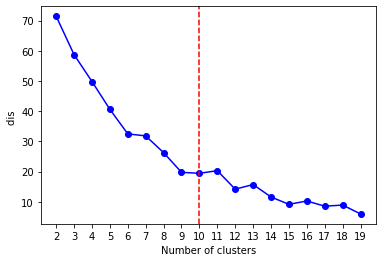

In [715]:
plt.plot(range(2,20), dis_list, 'bo-')
plt.xticks(range(2,20))
plt.xlabel('Number of clusters')
plt.ylabel('dis ')
#elbow_point = np.array([7])
plt.axvline(x=10, color='r', linestyle='--')
plt.show()

- According to the elbow method, we choose k=10 as the optimal value.
- The optimal value of k represents the number of clusters that best captures the structure of the data
- Each cluster represents a group of genes that share similar expression patterns

2.2.5

In [716]:
cur_dis,cls,center = K_means(T,10,iteration = 500,earlystop=True)
# get number of samples in each cluster
le_cls, count_cls = np.unique(cls, return_counts=True)
print("the cluster classes are: {}".format(le_cls), "and the number of elements in each cluster are respectively: {}".format(count_cls))

the cluster classes are: [0 1 2 3 4 5 6 7 8 9] and the number of elements in each cluster are respectively: [ 2 10 23  5 15  6  9  2  7 16]


In [717]:
max_cls = le_cls[np.argmax(count_cls)]
print("the biggest cluster is: {}".format(max_cls), "and the number of elements in this cluster is : {}".format(count_cls[np.argmax(count_cls)]))
#index of cluster with max number of samples
idx = np.where(cls == max_cls)[0]
print("the elements in this biggest cluster: {}".format(idx))

the biggest cluster is: 2 and the number of elements in this cluster is : 23
the elements in this biggest cluster: [ 8  9 10 12 14 15 16 17 18 37 41 45 46 47 48 52 53 54 65 66 81 90 93]


In [719]:
data_prime=data[:,idx]

In [720]:
# compute the correlation matrix
correlation_matrix_prime= np.corrcoef(data_prime, rowvar=False)
# set the threshold of the correlation matrix, only keep the elements with absolute value larger than 0.75
correlation_matrix_prime[np.abs(correlation_matrix_prime) < 0.75] = 0
# set the diagonal elements to 0
np.fill_diagonal(correlation_matrix_prime, 0)
# set the adjacency matrix
adjacency_matrix_prime = correlation_matrix_prime
isnan=np.isnan(correlation_matrix_prime)

In [721]:
from scipy.sparse import linalg
# define diagonal matrix of node degrees
weighted_degree_prime = adjacency_matrix_prime.sum(axis=1) 
# create diagonal matrix of degree
D_prime = np.diag(weighted_degree_prime)

In [722]:
# define Laplacian
L_prime = D_prime-adjacency_matrix_prime

In [723]:
# computing inverse square root vector of degree
weighted_degree_sqrt_prime = 1.0 / np.sqrt(weighted_degree_prime)
# set a diagonal matrix of the inverse square root of degree
D_inv_sqrt_prime = np.diag(weighted_degree_sqrt_prime)
# define the normalised Laplacian
L_norm_prime = np.eye(adjacency_matrix_prime.shape[0]) - D_inv_sqrt_prime.dot(adjacency_matrix_prime.dot(D_inv_sqrt_prime))
weighted_degree_sqrt_prime

array([0.23733363, 0.23974669, 0.23937733, 0.27669152, 0.41653648,
       0.30880836, 0.23161876, 0.2250837 , 0.24240374, 0.24075181,
       0.22911774, 0.24559054, 0.26106676, 0.25640648, 0.27159053,
       0.23732292, 0.2453054 , 0.23612212, 0.24136833, 0.23609951,
       0.23229577, 0.23397301, 0.25524899])

In [727]:
# Compute the first two eigenvectors of the normalised Laplacian
eigvals_sub, eigvecs_sub = np.linalg.eig(L_norm_prime)
idx_sorted_sub = np.argsort(eigvals_sub)
# get the second eigenvector
second_eigenvector = eigvecs_sub[:, idx_sorted_sub[1]]
spectral_partition = second_eigenvector
spectral_partition[spectral_partition<0] = 0
spectral_partition[spectral_partition>0] = 1
spectral_partition

array([0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 0.])

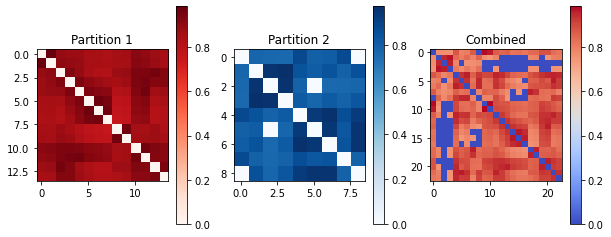

In [731]:
partition1_nodes = np.where(label == 0)[0]
partition2_nodes = np.where(label == 1)[0]

# Separate adjacency matrix by partition
part1_matrix = adjacency_matrix_prime[label == 1][:, label == 1]
part2_matrix = adjacency_matrix_prime[label == 0][:, label == 0]
new_node_order = np.concatenate((partition1_nodes, partition2_nodes))
adjacency_com_prime = adjacency_matrix_prime[new_node_order][:, new_node_order]

# Plot heatmaps
fig, axs = plt.subplots(1, 3, figsize=(10, 4))
im1 = axs[0].imshow(part1_matrix, cmap='Reds')
axs[0].set_title('Partition 1')
im2 = axs[1].imshow(part2_matrix, cmap='Blues')
axs[1].set_title('Partition 2')
im3 = axs[2].imshow(adjacency_com_prime, cmap='coolwarm')
axs[2].set_title('Combined')
fig.colorbar(im1, ax=axs[0])
fig.colorbar(im2, ax=axs[1])
fig.colorbar(im3, ax=axs[2])
plt.show()

- Firstly we can observe that the graph named as 'combined' has involved the other two heatmaps, one in the top left corner, and the other in the bottom right corner, and in this combined graph, the color pixel along the diagonal represents the the number link between nodes within a specific partition. The deeper red it is, the more links within partition.
- Now in terms of the areas not following the main diagonal, they represent the links across the two partitions.To be specific, the blue 'empty' space has the value of zero, means it is completely disconnected between several specific nodes in partition 1 and some other specific nodes in partition 2.
- This graph makes sense, as it implies the 


2.2.6

In [732]:
# subdegree
sub_degree = np.sum(adjacency_matrix_prime,axis=1)
sub_degree_centrality = sub_degree / np.sum(adjacency_matrix_prime)
# top 5 nodes with highest degree
idx_top5 = np.argsort(sub_degree_centrality)[-5:]
#print nodes with highest degree
print("nodes with highest degree centrality:",sub_degree_centrality[idx_top5],"their index is:",idx_top5)

nodes with highest degree centrality: [0.04894775 0.04965714 0.04994785 0.05104425 0.05289032] their index is: [21 20  6 10  7]


In [733]:
sub_degree_centrality

array([0.04757138, 0.04661858, 0.04676256, 0.03500037, 0.01544394,
       0.0280987 , 0.04994785, 0.05289032, 0.04560219, 0.04623014,
       0.05104425, 0.04442639, 0.03931526, 0.04075738, 0.03632746,
       0.04757567, 0.04452973, 0.0480608 , 0.04599427, 0.04807   ,
       0.04965714, 0.04894775, 0.04112787])

We notice that the top five degree centralities here (in subgraph) are larger than the top five calculated in 2.2.2 (in graph), that because according to the formula of degree centrality, if the node is connected with more other nodes, then the denominator is smaller, so the result as degree centrality is higher. (And a node in a full graph but not a defined subgraph has more access to freely connecting, while nodes restricted in a subgraph is unlikely to have many external links, as we have seen in the partition example in 2.2.5)
The most obvious example would be, considering a node in a subgraph which is part of the graph, it is likely to be linked to more edges in a full graph, so the degree centrality of the code is lower in the full graph.